# Sentimental analysis with NLTK and Transformers


In [31]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

plt.style.use("ggplot")

import nltk


In [32]:
# Reading the data
df = pd.read_csv('./Reviews.csv')
print(df.shape)
#Looks like the dataframe is huge let's use just a little portion of it
df = df.head(500)
print(df.shape)

(568454, 10)
(500, 10)


In [33]:
# Let me display the columns so they stay close 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      500 non-null    int64 
 1   ProductId               500 non-null    object
 2   UserId                  500 non-null    object
 3   ProfileName             500 non-null    object
 4   HelpfulnessNumerator    500 non-null    int64 
 5   HelpfulnessDenominator  500 non-null    int64 
 6   Score                   500 non-null    int64 
 7   Time                    500 non-null    int64 
 8   Summary                 500 non-null    object
 9   Text                    500 non-null    object
dtypes: int64(5), object(5)
memory usage: 39.2+ KB


## Quick EDA

Text(0.5, 0, 'Review stars')

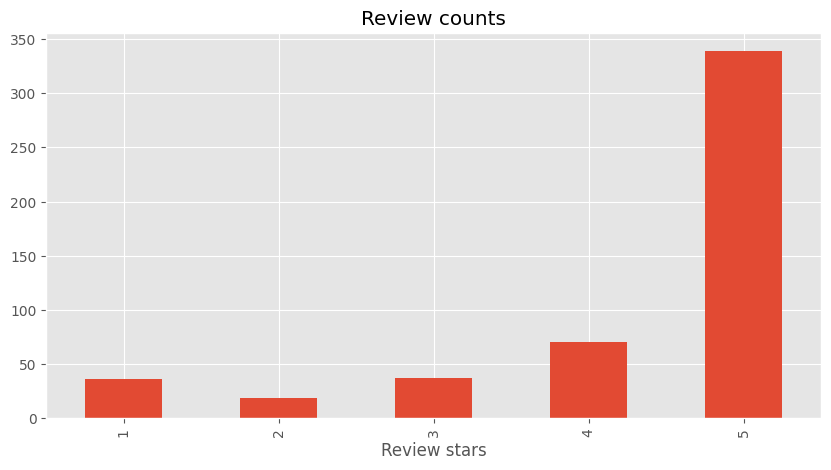

In [34]:
plot = df['Score'].value_counts().sort_index().plot(kind='bar',title='Review counts',figsize=(10,5))
plot.set_xlabel('Review stars')

# Basic NLTK

In [35]:
## Let's get an example

example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [36]:
tokens = nltk.word_tokenize(example)
## Represents what each part of the token represents
taggs  = nltk.pos_tag(tokens)


In [37]:
entities = nltk.chunk.ne_chunk(taggs)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# Step 1: Let's start with VADER Sentiment Scoring

We will use NLTK's ``SentimentIntensityAnalyser`` to get values like neg/neu/pos

In [38]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
sia = SentimentIntensityAnalyzer()

In [39]:
sia.polarity_scores('I am so happy!')
#Compound represents how negative or positive is this sentence [-1,1]

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [40]:
sia.polarity_scores('This is a really bad day!')

{'neg': 0.505, 'neu': 0.495, 'pos': 0.0, 'compound': -0.623}

In [41]:
print(example)
sia.polarity_scores(example)


This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [42]:
# Running the polarity score on the all dataframe
res = {}
for i, row in tqdm(df.iterrows(),total=len(df)):
    text = row['Text']
    myId = row['Id']
    res[myId] = sia.polarity_scores(text)


  0%|          | 0/500 [00:00<?, ?it/s]

In [43]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index':'Id'})
vaders = vaders.merge(df,how='left')

In [44]:
# Now we have sentiment score and the remaining metadata of the dataframe
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Ploting VADER results

Text(0.5, 1.0, 'Compound Score by Amazon Star Review')

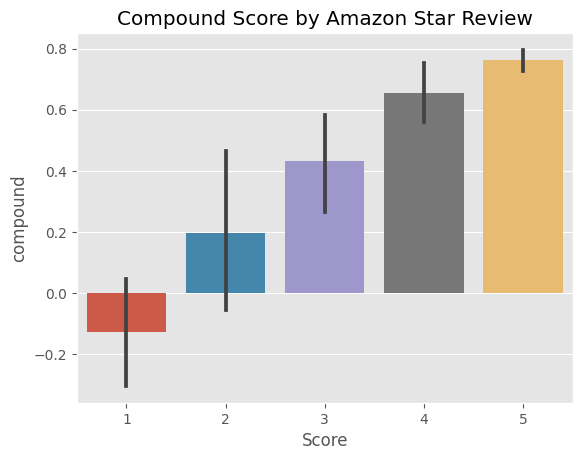

In [45]:
plot  = sns.barplot(data=vaders,x='Score',y='compound')
plot.set_title('Compound Score by Amazon Star Review')


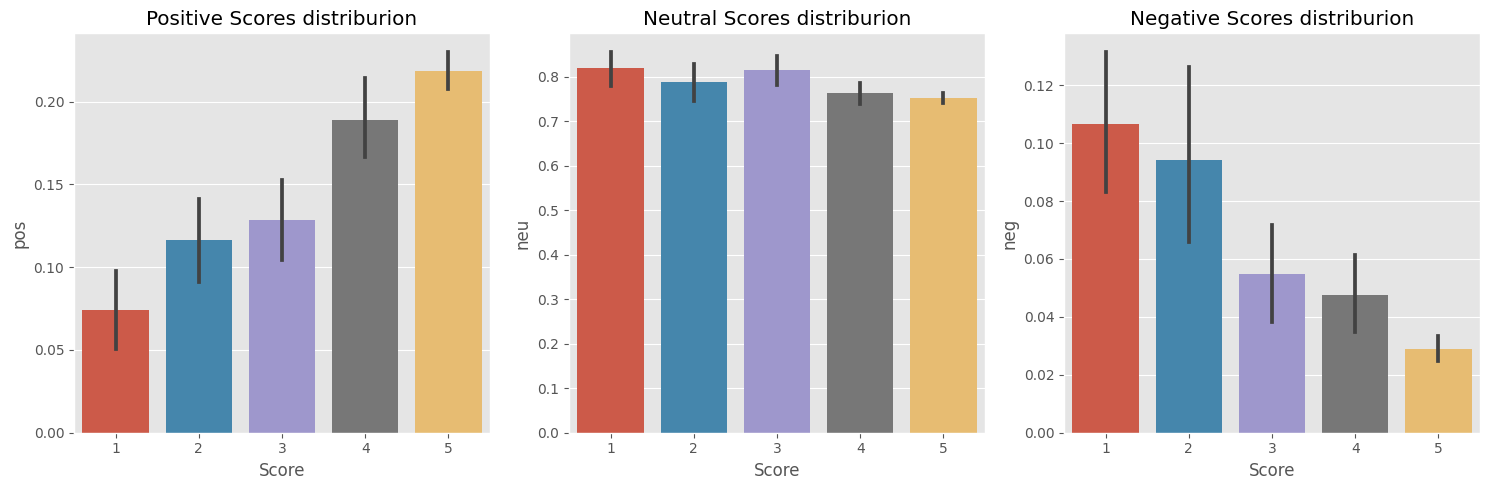

In [46]:
fig , axs = plt.subplots(1,3,figsize=(15,5))
sns.barplot(data=vaders,x='Score',y='pos',ax=axs[0])
sns.barplot(data=vaders,x='Score',y='neu',ax=axs[1])
sns.barplot(data=vaders,x='Score',y='neg',ax=axs[2])

axs[0].set_title('Positive Scores distriburion')
axs[1].set_title('Neutral Scores distriburion')
axs[2].set_title('Negative Scores distriburion')

plt.tight_layout()
plt.show()

# Step 3. Roberta Pretrained Model

* Use a model trained a large corpus of data.

* Transformer model accounts for the words but also the context related to other words

In [47]:
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [48]:
task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

